In [1]:
import sys
import os
import shutil
import time

import traceback
import signal as sg

from pathlib import Path
import h5py
import json
import pickle

import scipy
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(style='whitegrid', palette='muted')

## added TreeMazeanalyses folder using the following command
## conda develop /home/alexgonzalez/Documents/TreeMazeAnalyses2
import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Pre_Processing.pre_process_functions as pp
import TreeMazeAnalyses2.Sorting.sort_functions as sf

import spikeextractors as se
import spikesorters as ss
import spiketoolkit as st

sns.set(style= 'whitegrid', palette= 'muted')

import signal as sg

from importlib import reload

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        sg.signal(sg.SIGALRM, self.handle_timeout)
        sg.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        sg.alarm(0)


In [2]:
print(os.path.dirname(os.path.abspath('__file__')))
print(os.getcwd())


/home/alexgonzalez/Documents
/home/alexgonzalez/Documents


In [3]:
subject_id = 'Li'
sorter = 'KS2'
data_folder = Path('/Data_SSD2T/Data/PreProcessed/', subject_id)

task_table_file = data_folder / 'TasksDir' / ('sort_{}_{}.json'.format(subject_id,sorter))
with task_table_file.open(mode='r') as f:
    task_table = json.load(f)



In [5]:
task_table['1']    

{'session_name': 'Li_T3g_052818',
 'session_path': '/Data_SSD2T/Data/PreProcessed/Li/Li_T3g_052818',
 'files': {'1': {'session': 'Li_T3g_052818',
   'task_type': 'KS2',
   'file_path': '/Data_SSD2T/Data/PreProcessed/Li/Li_T3g_052818/tt_2.npy',
   'file_header_path': '/Data_SSD2T/Data/PreProcessed/Li/Li_T3g_052818/tt_2_info.pickle',
   'tt_id': '2',
   'save_path': '/Data_SSD2T/Data/Sorted/Li/Li_T3g_052818/tt_2'},
  '2': {'session': 'Li_T3g_052818',
   'task_type': 'KS2',
   'file_path': '/Data_SSD2T/Data/PreProcessed/Li/Li_T3g_052818/tt_5.npy',
   'file_header_path': '/Data_SSD2T/Data/PreProcessed/Li/Li_T3g_052818/tt_5_info.pickle',
   'tt_id': '5',
   'save_path': '/Data_SSD2T/Data/Sorted/Li/Li_T3g_052818/tt_5'},
  '3': {'session': 'Li_T3g_052818',
   'task_type': 'KS2',
   'file_path': '/Data_SSD2T/Data/PreProcessed/Li/Li_T3g_052818/tt_6.npy',
   'file_header_path': '/Data_SSD2T/Data/PreProcessed/Li/Li_T3g_052818/tt_6_info.pickle',
   'tt_id': '6',
   'save_path': '/Data_SSD2T/Data/S

In [6]:
task_num = 1
task_num_str=str(task_num)
tasks_info = task_table[task_num_str]
session_name = tasks_info['session_name']
n_files = tasks_info['n_files']
subtask_list = tasks_info['files']
print("Processing Session {}".format(session_name))

subtask_num = 1
subtask_num_str = str(subtask_num)
active_subtask = subtask_list[subtask_num_str]

print(" -- Task {} on tt {}".format(active_subtask['task_type'], active_subtask['tt_id']))

Processing Session Li_T3g_052818
 -- Task KS2 on tt 2


In [7]:
# load task data
data = np.load(active_subtask['file_path'])
with open(active_subtask['file_header_path'],'rb') as f:
    data_info = pickle.load(f)

In [8]:
print('Data Information Fields:')
print(list(data_info.keys()))


Data Information Fields:
['data_dir', 'session', 'fs', 'tt_num', 'n_chans', 'chan_files', 'a_ds', 'ref_chan', 'chan_ids', 'input_range', 'tt_geom', 'bad_chan_thr', 'n_samps', 'tB', 'tE', 'Raw', 'chan_code', 'bad_chans']


In [11]:
active_subtask


{'session': 'Li_T3g_052818',
 'task_type': 'KS2',
 'file_path': '/Data_SSD2T/Data/PreProcessed/Li/Li_T3g_052818/tt_2.npy',
 'file_header_path': '/Data_SSD2T/Data/PreProcessed/Li/Li_T3g_052818/tt_2_info.pickle',
 'tt_id': '2',
 'save_path': '/Data_SSD2T/Data/Sorted/Li/Li_T3g_052818/tt_2'}

In [15]:
# filter data to correct range and save
SOS,_ = pp.get_sos_filter_bank(['Sp'],fs=data_info['fs'])
spk_data = np.zeros_like(data)

assert data_info['n_chans']==spk_data.shape[0], "Inconsistent formating in the data files. Aborting."

t0 = time.time()
for ch in range(data_info['n_chans']):
    spk_data[ch] = scipy.signal.sosfiltfilt(SOS, data[ch])
    print('',end='.')
t1 = time.time()

print('\nTime to spk filter data {0:0.2f}s'.format(t1-t0))

....
Time to spk filter data 4.22s


In [16]:
pp = reload(pp)
chan_masks = pp.create_chan_masks(data_info['Raw']['ClippedSegs'],data_info['n_samps'])
chan_mad = pp.get_signals_mad(spk_data,chan_masks)
data_info['Spk'] = {'mad':chan_mad}
print('Channels Median Absolute Deviation in the Spike Frequency Range:')
print(chan_mad)


updated_file_header_path = Path(active_subtask['save_path'], Path(active_subtask['file_header_path']).name)
with updated_file_header_path.open(mode='wb') as file_handle:
    pickle.dump(data_info, file_handle, protocol = pickle.HIGHEST_PROTOCOL )
    

Channels Median Absolute Deviation in the Spike Frequency Range:
[2.75488281 2.66661787 7.86177588 7.71271038]


PosixPath('/Data_SSD2T/Data/Sorted/Li/Li_T3g_052818/tt_2/tt_2_info.pickle')

'/Data_SSD2T/Data/Sorted/Li/Li_T3g_052818/tt_2'

In [17]:
spk_data_masked = se.NumpyRecordingExtractor(timeseries=spk_data*chan_masks, geom=data_info['tt_geom'], sampling_frequency=data_info['fs'])

In [264]:
pp = reload(pp)
sf = reload(sf)
save_path = Path(active_subtask['save_path'], sorter)
out = sf.sort_data(spk_data_masked, save_path, sorter = active_subtask['task_type'])


Setting KILOSORT2_PATH environment variable for subprocess calls to: /home/alexgonzalez/Documents/MATLAB/Kilosort2

Sorting with KS2
RUNNING SHELL SCRIPT: /Data_SSD2T/Data/Sorted/Li/Li_T3g_052818/tt_2/KS2/tmp_KS2/run_kilosort2.sh

Permission Error. Trying to run algorithm locally.
Time to sort using KS2 = 55.41s
Found 16 clusters


In [265]:
import spiketoolkit as st
st = reload(st)
st.postprocessing.export_to_phy(recording=spk_data_masked,sorting=out, output_folder=str(save_path), compute_pc_features=False, compute_amplitudes=False,max_channels_per_template=4, n_jobs=10)

RecordingExtractor is not dumpable and can't be processed in parallel


In [268]:
updated_file_header_path = Path(active_subtask['save_path'], Path(active_subtask['file_header_path']).name)
with updated_file_header_path.open(mode='wb') as file_handle:
    pickle.dump(data_info, file_handle, protocol = pickle.HIGHEST_PROTOCOL )

In [267]:
updated_file_header_path

PosixPath('/Data_SSD2T/Data/Sorted/Li/Li_T3g_052818/tt_2/tt_2_info.pickle')

In [271]:
sf = reload(sf)
cluster_stats = sf.get_cluster_stats(out, spk_data_masked.get_traces(), data_info)
cluster_stats_file_path = Path(save_path,'cluster_stats.csv')
cluster_stats.to_csv( cluster_stats_file_path)

In [262]:
cluster_stats['tt']=2
cluster_stats


,cl_num,sorter,fr,isi_viol_rate,n_spikes,n_isi_viol,snr,amp_ch,amp_med_ch,amp_mad_ch,valid,tt
KS2_0,0.0,KS2,3.438736,0.055465,5243.0,2.0,3.026040,0.0,8.336386,2.318708,False,2
KS2_1,1.0,KS2,3.414469,0.028128,5206.0,1.0,2.057627,2.0,16.176605,7.001418,False,2
KS2_2,2.0,KS2,1.964992,0.339725,2996.0,4.0,1.057455,0.0,2.913165,2.897693,False,2
KS2_3,3.0,KS2,3.150809,0.066066,4804.0,2.0,1.927785,2.0,15.155817,7.086122,False,2
KS2_4,4.0,KS2,3.409878,0.028204,5199.0,1.0,1.769928,3.0,13.650940,7.030299,False,2
KS2_5,5.0,KS2,2.526419,0.154134,3852.0,3.0,0.923358,3.0,7.121590,7.121590,False,2
KS2_6,6.0,KS2,2.552653,0.050327,3892.0,1.0,2.854847,2.0,22.444164,6.671808,False,2
KS2_7,7.0,KS2,3.241319,0.031214,4942.0,1.0,3.175373,3.0,24.490730,6.639705,False,2
KS2_8,8.0,KS2,4.074276,0.000000,6212.0,0.0,2.570149,2.0,20.205933,6.879059,False,2
KS2_9,9.0,KS2,4.844270,0.000000,7386.0,0.0,2.136969,3.0,16.481819,6.253567,False,2


In [259]:
data_info['tt_num']

'2'

In [ ]:
n_tt = 16
n_tt_ch = 4

channel_groups = {}
    for tt in np.arange

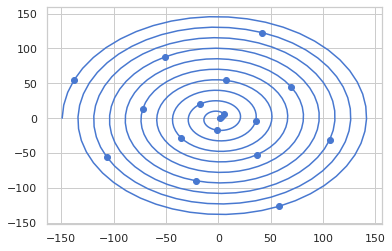

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
a = 1.5
b = -2.4
t = np.linspace(0,20*np.pi,500)
x = (a + b*t) * np.cos(t)
y = (a + b*t) * np.sin(t)
plt.plot(x, y)#, col=2, lwd=3)

locs = np.arange(0,n,np.int(n/16))

plt.scatter(x[locs],y[locs])

#abline(h=0, v=0, col="grey")

In [130]:
def circ_points(r, n_points):
    
    n_samps = 1000
    interval = np.int(np.floor(n_samps/n_points))
    samps = np.mod(np.arange(n_samps)+np.random.randint(n_samps),n_samps)[::interval]
    samps = samps[:n_points]
    
    th = np.linspace(0,2*np.pi,n_samps)
    x = r*np.cos(th)
    y = r*np.sin(th)
    
    return x[samps], y[samps]

(-674.9283587427475, 974.0829580122748, -878.9126484473348, 833.6475351203056)

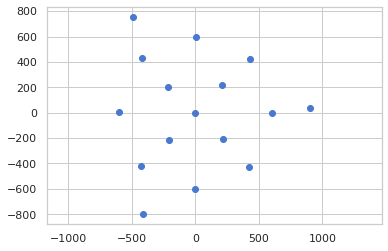

In [219]:
n_tt = 16
n_points = [1,4,8,3]
n_radii = 4
scale = 300
radii = np.arange(n_radii)*scale
tt_centers = np.zeros((n_tt,2))

x_points = []
y_points = []
idx_e = np.cumsum(np.array(n_points)).astype(int)
idx_s = np.concatenate((np.zeros(1),idx_e[:-1])).astype(int)
for ii,r in enumerate(radii):
    x,y = circ_points(r,n_points[ii])
    tt_centers[idx_s[ii]:idx_e[ii],0] = x
    tt_centers[idx_s[ii]:idx_e[ii],1] = y
    

    
#plt.scatter(tt_centers)
# plt.scatter(*circ_points(1,4))
# plt.scatter(*circ_points(2,8))
# plt.scatter(*circ_points(3,3))
plt.scatter(tt_centers[:,0],tt_centers[:,1])
plt.axis('equal')



In [171]:
ii=2
print(n_points[ii],np.sum(n_points[:ii+1]))
np.arange(n_points[ii],np.sum(n_points[:ii+1]))

8 13


array([ 7,  8,  9, 10, 11, 12])

In [199]:
circ_points(scale*0.75,4)

(array([ 202.32162335,   99.39595115, -202.01104708,  -98.76067972]),
 array([ -98.44267735,  201.85500959,   99.07843791, -202.16658513]))

In [242]:
chan_locs = {}
for tt in range(n_tt):
    x,y = circ_points(scale*0.1,4)
    x+=tt_centers[tt][0]
    y+=tt_centers[tt][1]
    z=np.stack((x,y)).T
    chan_locs[tt] = [ list(xy.astype(int)) for xy in z]


In [243]:
chan_locs

{0: [[-29, -2], [2, -29], [29, 2], [-2, 29]],
 1: [[198, 246], [177, 209], [214, 188], [235, 225]],
 2: [[-188, 199], [-211, 235], [-247, 212], [-224, 176]],
 3: [[-202, -247], [-176, -214], [-209, -188], [-235, -221]],
 4: [[197, -184], [197, -226], [239, -226], [239, -184]],
 5: [[-442, 408], [-400, 405], [-397, 448], [-439, 451]],
 6: [[-571, -5], [-589, 33], [-627, 16], [-610, -22]],
 7: [[-425, -450], [-397, -418], [-430, -390], [-457, -422]],
 8: [[12, -624], [20, -583], [-21, -575], [-29, -616]],
 9: [[446, -443], [437, -402], [396, -410], [404, -452]],
 10: [[588, 23], [572, -15], [612, -31], [627, 8]],
 11: [[418, 447], [401, 408], [440, 391], [457, 429]],
 12: [[10, 629], [-23, 603], [2, 570], [36, 596]],
 13: [[-466, 735], [-468, 777], [-510, 776], [-508, 733]],
 14: [[-380, -805], [-405, -771], [-439, -796], [-415, -830]],
 15: [[870, 32], [906, 10], [928, 46], [891, 68]]}

In [249]:
channel_groups = {}
for tt in range(n_tt):
    channels = np.arange(4,dtype=int)+4*tt
    channel_groups[tt] = {'channels':[],'label':[],'geometry':[]}
    channel_groups[tt]['channels'] = list(channels)
    channel_groups[tt]['label'] = ['ch_{}'.format(ch) for ch in channels]
    channel_groups[tt]['geometry'] = chan_locs[tt]
    
    
channel_groups

{0: {'channels': [0, 1, 2, 3],
  'label': ['ch_0', 'ch_1', 'ch_2', 'ch_3'],
  'geometry': [[-29, -2], [2, -29], [29, 2], [-2, 29]]},
 1: {'channels': [4, 5, 6, 7],
  'label': ['ch_4', 'ch_5', 'ch_6', 'ch_7'],
  'geometry': [[198, 246], [177, 209], [214, 188], [235, 225]]},
 2: {'channels': [8, 9, 10, 11],
  'label': ['ch_8', 'ch_9', 'ch_10', 'ch_11'],
  'geometry': [[-188, 199], [-211, 235], [-247, 212], [-224, 176]]},
 3: {'channels': [12, 13, 14, 15],
  'label': ['ch_12', 'ch_13', 'ch_14', 'ch_15'],
  'geometry': [[-202, -247], [-176, -214], [-209, -188], [-235, -221]]},
 4: {'channels': [16, 17, 18, 19],
  'label': ['ch_16', 'ch_17', 'ch_18', 'ch_19'],
  'geometry': [[197, -184], [197, -226], [239, -226], [239, -184]]},
 5: {'channels': [20, 21, 22, 23],
  'label': ['ch_20', 'ch_21', 'ch_22', 'ch_23'],
  'geometry': [[-442, 408], [-400, 405], [-397, 448], [-439, 451]]},
 6: {'channels': [24, 25, 26, 27],
  'label': ['ch_24', 'ch_25', 'ch_26', 'ch_27'],
  'geometry': [[-571, -5], [-5